#### 2024/05/21 宮崎聡 (ハワイ観測所)

### SciOps Night Log - 2024-03-23 で報告されているActuator8-60 Alarmが発生しているときの温度センサのデータを確認し、どのチャンネルが問題かを調べよ

In [329]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import subprocess
from subprocess import PIPE

def shell(command):
    print(command)
    proc = subprocess.run(command, shell=True, stdout=PIPE, stderr=PIPE, text=True)
    return proc.stdout, proc.stderr
    

#### データ切り出し

In [330]:
extractor = "dump-tsc-log -a -z"
inputFilePath = "/stars/2024/TSCL-20240323-17.pkt"
#outputFilePath = os.path.basename(inputFilePath) + "-L3-00B2.log"


names = ["PMFXS8-60 Temp MON1 Data", 
         "PMFXS8-60 Temp MON2 Data",
         "PMFXS8-60 Temp MON3 Data",
         "PMFXS8-60 Temp MON4 Data",
         "PMFXS8-60 Temp MON5 Data",
         "PMFXS8-60 Temp MON6 Data"]

extractNames = f''
for name in names:
    extractNames += f'-e \"{name}\" '

(_, outputText) = shell(f'{extractor} {extractNames} {inputFilePath}')
outputFilePath = outputText.split('\n')[-2][11:]
print(f'{outputFilePath} generated.')

dump-tsc-log -a -z -e "PMFXS8-60 Temp MON1 Data" -e "PMFXS8-60 Temp MON2 Data" -e "PMFXS8-60 Temp MON3 Data" -e "PMFXS8-60 Temp MON4 Data" -e "PMFXS8-60 Temp MON5 Data" -e "PMFXS8-60 Temp MON6 Data"  /stars/2024/TSCL-20240323-17.pkt
./TSCL-20240323-17.pkt-L3-00B2.log generated.


#### outliers検出方法の定義

In [331]:
def byPercentile(ts, cut):
    l = np.percentile(ts, cut)
    h = np.percentile(ts, 100-cut)
    outliers = ts[(ts > h) | (ts < l)]
    return outliers


def byMovingMean(ts, window, cut):
    moving_average = ts.rolling(window=window).mean()

    # 差分を計算
    diff = ts - moving_average

    # 外れ値を検出（ここでは差分が標準偏差の3倍を超えるものを外れ値とする）
    threshold = cut * diff.std()
    outliers = ts[np.abs(diff) > threshold]
    return outliers

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def byExponentialSmoothing(ts):
    # エクスポネンシャルスムージングを適用
    model = ExponentialSmoothing(ts, trend='add', seasonal=None)
    fit = model.fit(smoothing_level=0.8, optimized=False)
    smoothed = fit.fittedvalues

    # 差分を計算
    diff = ts - smoothed

    # 外れ値を検出（ここでは差分が標準偏差の3倍を超えるものを外れ値とする）
    threshold = 3 * diff.std()
    outliers = ts[np.abs(diff) > threshold]
    return outliers

def byPctChange(ts, cut):
    returns = ts.pct_change()

    # 外れ値を検出（ここでは変動率が標準偏差の3倍を超えるものを外れ値とする）
    threshold = cut * returns.std()
    outliers = ts[np.abs(returns) > threshold]
    return outliers


2024-03-24 05:25:30.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:31.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:32.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:33.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:34.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:35.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:36.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:37.4 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:38.4 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:39.4 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:40.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:41.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:42.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:43.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:44.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:45.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:46.3 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:47.4 PMFXS8-60 Temp MON1 Data : 5.5
2024-03-24 05:25:48.4 PMFXS8-60 Temp MON1 Data

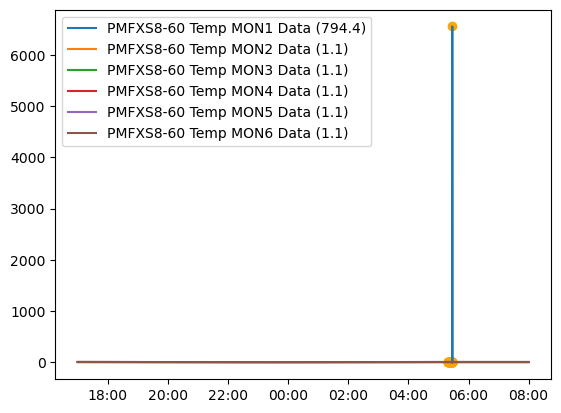

In [332]:
df = pd.read_table(outputFilePath)
data = df.values
df['datetime']= pd.to_datetime(df['#rxdate'] + ' ' + df['rxtime(HST)'])

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
for i, name in zip(range(3, 3+len(names)), names):
    ts = pd.Series(data[:,i], index=df['datetime'])
    outliers = byPercentile(ts, 0.1)
#    outliers = byMovingMean(ts, 10, 10)
#    outliers = byExponentialSmoothing(ts)
#    outliers = byPctChange(ts, 5)
    ax.plot(df['datetime'], data[:,i], label=f'{name} ({np.var(data[:,i]):.1f})')
    ax.scatter(outliers.index, outliers, color='orange')
    for t in outliers.index:
        print(f'{t.strftime("%Y-%m-%d %H:%M:%S.%f")[:21]} {name} : {ts[t]}')
            
plt.legend()
plt.show()

In [333]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53996 entries, 0 to 53995
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   #rxdate                   53996 non-null  object        
 1   rxtime(HST)               53996 non-null  object        
 2   sec-from-00:00:00UTC      53996 non-null  float64       
 3   PMFXS8-60 Temp MON1 Data  53996 non-null  float64       
 4   PMFXS8-60 Temp MON2 Data  53996 non-null  float64       
 5   PMFXS8-60 Temp MON3 Data  53996 non-null  float64       
 6   PMFXS8-60 Temp MON4 Data  53996 non-null  float64       
 7   PMFXS8-60 Temp MON5 Data  53996 non-null  float64       
 8   PMFXS8-60 Temp MON6 Data  53996 non-null  float64       
 9   datetime                  53996 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 4.1+ MB
